## Importing Libraries!

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Defining Simple Data for Understanding

In [3]:
corpus = ["basketball badminton cycling", "badminton cycling basketball", "cycling basketball badminton",
          "pizza burger sandwich", "burger sandwich pizza", "sandwich pizza burger"]

In [4]:
corpus = [sent.split(" ") for sent in corpus]
corpus

[['basketball', 'badminton', 'cycling'],
 ['badminton', 'cycling', 'basketball'],
 ['cycling', 'basketball', 'badminton'],
 ['pizza', 'burger', 'sandwich'],
 ['burger', 'sandwich', 'pizza'],
 ['sandwich', 'pizza', 'burger']]

In [5]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))
vocab

['basketball', 'burger', 'cycling', 'pizza', 'sandwich', 'badminton']

In [6]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}
print(word2index)

{'basketball': 0, 'burger': 1, 'cycling': 2, 'pizza': 3, 'sandwich': 4, 'badminton': 5}


In [7]:
#vocab size
voc_size = len(vocab)
print(voc_size)

6


In [8]:
#append UNK
vocab.append('<UNK>')

In [9]:
vocab

['basketball', 'burger', 'cycling', 'pizza', 'sandwich', 'badminton', '<UNK>']

In [10]:
word2index['<UNK>'] = 6
word2index

{'basketball': 0,
 'burger': 1,
 'cycling': 2,
 'pizza': 3,
 'sandwich': 4,
 'badminton': 5,
 '<UNK>': 6}

In [11]:
#just in case we need to use
index2word = {v:k for k, v in word2index.items()}
index2word

{0: 'basketball',
 1: 'burger',
 2: 'cycling',
 3: 'pizza',
 4: 'sandwich',
 5: 'badminton',
 6: '<UNK>'}

In [12]:
#vocab size
voc_size = len(vocab)
print(voc_size)

7


# 1. Word2Vec

Let's work on skipgram-based implementation of word2vec.

## 1.1 Prepare train data

In [13]:
for c in corpus:
    print(c)

['basketball', 'badminton', 'cycling']
['badminton', 'cycling', 'basketball']
['cycling', 'basketball', 'badminton']
['pizza', 'burger', 'sandwich']
['burger', 'sandwich', 'pizza']
['sandwich', 'pizza', 'burger']


In [14]:
#  Generating random batches of training data for skipgram

def random_batch(batch_size, word_sequence):

    # Make skipgram of one size window
    skip_grams = []
    # loop each word sequence
    # we starts from 1 because 0 has no context
    # we stop at second last for the same reason
    for sent in corpus:
        for i in range(1, len(sent) - 1):
            target = word2index[sent[i]]
            context = [word2index[sent[i - 1]], word2index[sent[i + 1]]]
            for w in context:
                skip_grams.append([target, w])

    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement

    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams[i][1]])  # context word, e.g., 3

    return np.array(random_inputs), np.array(random_labels)

### Testing the method

In [24]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus)

print("Target words: ", input_batch)
print("Context words: ", target_batch)

Target words:  [[2]
 [4]]
Context words:  [[0]
 [1]]


## 1.2 Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [16]:
class Skipgram(nn.Module):

    def __init__(self, vocab_size, emb_size):
        super(Skipgram,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size)
        self.embedding_u = nn.Embedding(vocab_size, emb_size)

    def forward(self, center_words, target_words, all_vocabs):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        all_embeds    = self.embedding_u(all_vocabs) #   [batch_size, voc_size, emb_size]

        scores      = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        norm_scores = all_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, voc_size, emb_size] @ [batch_size, emb_size, 1] = [batch_size, voc_size, 1] = [batch_size, voc_size]

        nll = -torch.mean(torch.log(torch.exp(scores)/torch.sum(torch.exp(norm_scores), 1).unsqueeze(1))) # log-softmax
        # scalar (loss must be scalar)

        return nll # negative log likelihood

## 1.3 Training

In [17]:
batch_size     = 2 # mini-batch size
embedding_size = 2 #so we can later plot
model          = Skipgram(voc_size, embedding_size)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

#use for the normalized term in the probability calculation
all_vocabs = prepare_sequence(list(vocab), word2index).expand(batch_size, len(vocab))  # [batch_size, voc_size]
all_vocabs.shape

torch.Size([2, 7])

In [19]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
import time

# Training
num_epochs = 5000
for epoch in range(num_epochs):

    start = time.time()

    input_batch, target_batch = random_batch(batch_size, corpus)
    input_batch  = torch.LongTensor(input_batch)  #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch) #[batch_size, 1]

    optimizer.zero_grad()
    loss = model(input_batch, target_batch, all_vocabs)

    loss.backward()
    optimizer.step()

    end = time.time()

    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch: 1000 | cost: 1.944652 | time: 0m 0s
Epoch: 2000 | cost: 1.174757 | time: 0m 0s
Epoch: 3000 | cost: 0.936937 | time: 0m 0s
Epoch: 4000 | cost: 1.328307 | time: 0m 0s
Epoch: 5000 | cost: 1.502067 | time: 0m 0s


## 1.4 Plotting the embeddings

In [21]:
#list of vocabs
vocab[:10]

['basketball', 'burger', 'cycling', 'pizza', 'sandwich', 'badminton', '<UNK>']

In [22]:
word = vocab[0]

In [23]:
#numericalization
id = word2index[word]
id

0

In [25]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [26]:
#get the embedding by averaging
v_embed = model.embedding_v(id_tensor)
u_embed = model.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[-0.4931, -1.2286]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.3559, -0.0495]], grad_fn=<EmbeddingBackward0>))

In [27]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(-0.6391, grad_fn=<SelectBackward0>)

In [28]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor)
    word_embed = (v_embed + u_embed) / 2
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

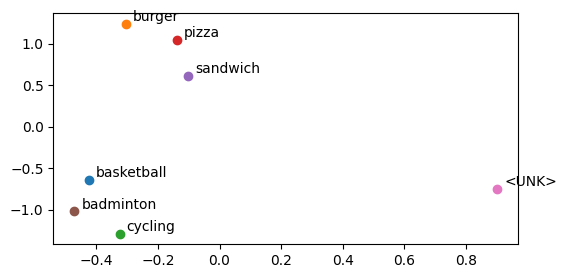

In [29]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

# 2. GloVE

Let's work on implementation of GloVE.


## 2.1 Build Co-occurence Matrix X
Here, we need to count the co-occurence of two words given some window size. We gonna use window size of 1.

In [30]:
from collections import Counter

X_i = Counter(flatten(corpus)) # X_i
X_i

Counter({'basketball': 3,
         'badminton': 3,
         'cycling': 3,
         'pizza': 3,
         'burger': 3,
         'sandwich': 3})

In [31]:
# Make skip gram of one size window
skip_grams = []
# loop each word sequence
# we starts from 1 because 0 has no context
# we stop at second last for the same reason
for sent in corpus:
    for i in range(1, len(sent) - 1):
        target = sent[i]
        context = [sent[i - 1], sent[i + 1]]
        for w in context:
            skip_grams.append((target, w))

skip_grams

[('badminton', 'basketball'),
 ('badminton', 'cycling'),
 ('cycling', 'badminton'),
 ('cycling', 'basketball'),
 ('basketball', 'cycling'),
 ('basketball', 'badminton'),
 ('burger', 'pizza'),
 ('burger', 'sandwich'),
 ('sandwich', 'burger'),
 ('sandwich', 'pizza'),
 ('pizza', 'sandwich'),
 ('pizza', 'burger')]

In [32]:
X_ik_skipgram = Counter(skip_grams) # Co-occurece in window size 1
X_ik_skipgram

Counter({('badminton', 'basketball'): 1,
         ('badminton', 'cycling'): 1,
         ('cycling', 'badminton'): 1,
         ('cycling', 'basketball'): 1,
         ('basketball', 'cycling'): 1,
         ('basketball', 'badminton'): 1,
         ('burger', 'pizza'): 1,
         ('burger', 'sandwich'): 1,
         ('sandwich', 'burger'): 1,
         ('sandwich', 'pizza'): 1,
         ('pizza', 'sandwich'): 1,
         ('pizza', 'burger'): 1})

## 2.2 Weighting function

GloVe includes a weighting function to scale down too frequent words.?

In [33]:
#simply a normalized function...don't worry too much
def weighting(w_i, w_j, X_ik):

    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1

    x_max = 100 #100 # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75

    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum

    return result

In [34]:
from itertools import combinations_with_replacement

X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling

for bigram in combinations_with_replacement(vocab, 2):
    if X_ik_skipgram.get(bigram) is not None:  #matches
        co_occer = X_ik_skipgram[bigram]  #get the count from what we already counted
        X_ik[bigram] = co_occer + 1 # + 1 for stability issue
        X_ik[(bigram[1],bigram[0])] = co_occer+1   #count also for the opposite
    else:
        pass

    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

print(f"{X_ik=}")
print(f"{weighting_dic=}")

X_ik={('basketball', 'cycling'): 2, ('cycling', 'basketball'): 2, ('basketball', 'badminton'): 2, ('badminton', 'basketball'): 2, ('burger', 'pizza'): 2, ('pizza', 'burger'): 2, ('burger', 'sandwich'): 2, ('sandwich', 'burger'): 2, ('cycling', 'badminton'): 2, ('badminton', 'cycling'): 2, ('pizza', 'sandwich'): 2, ('sandwich', 'pizza'): 2}
weighting_dic={('basketball', 'basketball'): 0.03162277660168379, ('basketball', 'burger'): 0.03162277660168379, ('burger', 'basketball'): 0.03162277660168379, ('basketball', 'cycling'): 0.053182958969449884, ('cycling', 'basketball'): 0.053182958969449884, ('basketball', 'pizza'): 0.03162277660168379, ('pizza', 'basketball'): 0.03162277660168379, ('basketball', 'sandwich'): 0.03162277660168379, ('sandwich', 'basketball'): 0.03162277660168379, ('basketball', 'badminton'): 0.053182958969449884, ('badminton', 'basketball'): 0.053182958969449884, ('basketball', '<UNK>'): 0.03162277660168379, ('<UNK>', 'basketball'): 0.03162277660168379, ('burger', 'burg

## 2.3 Prepare train data


In [35]:
for c in corpus:
    print(c)

['basketball', 'badminton', 'cycling']
['badminton', 'cycling', 'basketball']
['cycling', 'basketball', 'badminton']
['pizza', 'burger', 'sandwich']
['burger', 'sandwich', 'pizza']
['sandwich', 'pizza', 'burger']


In [36]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):

    #convert to id since our skip_grams is word, not yet id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]

    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False) #randomly pick without replacement

    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams_id[i][1]])  # context word, e.g., 3

        #get cooc
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])

        #get weighting
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])

    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

### Testing the method

In [37]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

print("Input: ", input_batch)
print("Target: ", target_batch)
print("Cooc: ", cooc_batch)
print("Weighting: ", weighting_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[3]
 [5]]
Target:  [[4]
 [2]]
Cooc:  [[0.69314718]
 [0.69314718]]
Weighting:  [[0.05318296]
 [0.05318296]]


## 2.4 Model

$$J(\theta) = \sum_{V}^{i,j=1} f(X_{ij})(w^{T}_{i}\tilde{w_{j}}+b_{i}+\tilde{b_{j}}-\log X_{ij})$$

In [38]:
class GloVe(nn.Module):

    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding

        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)

    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]

        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)

        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)

        return torch.sum(loss)

## 2.5 Training

In [39]:
batch_size     = 10 # mini-batch size
embedding_size = 2 #so we can later plot
model          = GloVe(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [41]:
import time

# Training
num_epochs = 5000
for epoch in range(num_epochs):

    start = time.time()

    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]

    optimizer.zero_grad()
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)

    loss.backward()
    optimizer.step()

    end = time.time()

    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")

Epoch: 1000 | cost: 0.016419 | time: 0m 0s
Epoch: 2000 | cost: 0.000000 | time: 0m 0s
Epoch: 3000 | cost: 0.000000 | time: 0m 0s
Epoch: 4000 | cost: 0.000000 | time: 0m 0s
Epoch: 5000 | cost: 0.000000 | time: 0m 0s


## 2.6 Plotting the embeddings

In [42]:
#list of vocabs
vocab[:10]

['basketball', 'burger', 'cycling', 'pizza', 'sandwich', 'badminton', '<UNK>']

In [43]:
word = vocab[0]

In [44]:
#numericalization
id = word2index[word]
id

0

In [45]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [46]:
#get the embedding by averaging
v_embed = model.embedding_v(id_tensor)
u_embed = model.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[-0.7633, -0.8881]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.9821, -1.3215]], grad_fn=<EmbeddingBackward0>))

In [47]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(-1.1048, grad_fn=<SelectBackward0>)

In [48]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor)
    word_embed = (v_embed + u_embed) / 2
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

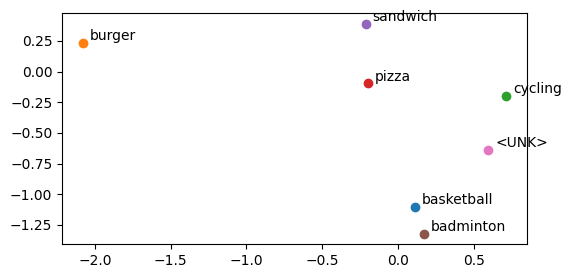

In [49]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [50]:
vocab

['basketball', 'burger', 'cycling', 'pizza', 'sandwich', 'badminton', '<UNK>']

In [53]:
#let's try similarity between first and second, and second and third
basketball   = get_embed('basketball')
burger       = get_embed('burger')
cycling      = get_embed('cycling')

In [54]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

print(f"basketball vs. burger: ",      cos_sim(basketball, burger))
print(f"basketball vs. cycling: ",     cos_sim(basketball, cycling))
print(f"basketball vs. basketball: ",  cos_sim(basketball, basketball))

basketball vs. burger:  -0.2087679488057281
basketball vs. cycling:  0.3632651530288507
basketball vs. basketball:  1.0


In [55]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"basketball vs. burger: ",      cos_sim(basketball, burger))
print(f"basketball vs. cycling: ",     cos_sim(basketball, cycling))
print(f"basketball vs. basketball: ",  cos_sim(basketball, basketball))

basketball vs. burger:  -0.20876794880572813
basketball vs. cycling:  0.36326515302885065
basketball vs. basketball:  1


# 3. GloVE (Gensim)

For looking at word vectors, we'll use Gensim. Gensim isn't really a deep learning package. It's a package for for word and text similarity modeling, which started with topic models and grew into SVD and neural word representations. But its efficient and scalable, and quite widely used. We gonna use GloVe embeddings, downloaded at the Glove page.

In [56]:
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath('/content/drive/MyDrive/NLP resources/glove.6B.100d.txt')
model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

In [57]:
#return the vectors
model['coffee'].shape

(100,)

## 3.1 Similarity

In [58]:
model.most_similar('obama')

[('barack', 0.937216579914093),
 ('bush', 0.927285373210907),
 ('clinton', 0.896000325679779),
 ('mccain', 0.8875633478164673),
 ('gore', 0.8000321388244629),
 ('hillary', 0.7933662533760071),
 ('dole', 0.7851964831352234),
 ('rodham', 0.7518897652626038),
 ('romney', 0.7488929629325867),
 ('kerry', 0.7472624182701111)]

In [59]:
model.most_similar('language')

[('languages', 0.8260655403137207),
 ('word', 0.7464082837104797),
 ('spoken', 0.7381494045257568),
 ('arabic', 0.7318817377090454),
 ('english', 0.7214903831481934),
 ('dialect', 0.6912703514099121),
 ('vocabulary', 0.6908208727836609),
 ('text', 0.685594916343689),
 ('translation', 0.6810674667358398),
 ('words', 0.6715823411941528)]

In [60]:
#multiple meanings....
model.most_similar("plant")

[('plants', 0.8918153643608093),
 ('factory', 0.7068111896514893),
 ('farm', 0.6553632616996765),
 ('facility', 0.6538199782371521),
 ('production', 0.6336488127708435),
 ('produce', 0.6246358752250671),
 ('processing', 0.6155514121055603),
 ('fertilizer', 0.6091734170913696),
 ('waste', 0.6080260872840881),
 ('factories', 0.6015971302986145)]

In [61]:
model.most_similar(negative="plant")

[('gelu', 0.5752187967300415),
 ('vadm', 0.555915117263794),
 ('t.p.', 0.5507370233535767),
 ('debbah', 0.5472500324249268),
 ('korais', 0.5418546199798584),
 ('pól', 0.5410396456718445),
 ('karlene', 0.5345797538757324),
 ('gowans', 0.5318692326545715),
 ('erbas', 0.5316898822784424),
 ('machell', 0.5285011529922485)]

In [62]:
#woman + king - man
result = model.most_similar(positive=['woman', 'king'], negative=['man'])
print("{}: {:.4f}".format(*result[0]))

queen: 0.7699


In [63]:
result = model.most_similar(positive=['italy', 'sushi'], negative=['japan'])
print("{}: {:.4f}".format(*result[0]))

tapas: 0.6232


## 3.2 Cosine Similarity
Here we can conveniently use distance to find the cosine distance between two words. Note that distance = 1 - similarity.

In [64]:
w1 = "dog"
w2 = "cat"
w3 = "fruit"
w1_w2_dist = model.distance(w1, w2)
w1_w3_dist = model.distance(w1, w3)

#dog is much closer to cat then dog to fruit
w1_w2_dist, w1_w3_dist

(0.1201925277709961, 0.6231490671634674)

In [65]:
w1 = "happy" # synonym 1
w2 = "cheerful" # synonym 2
w3 = "sad" # antonym
w1_w2_dist = model.distance(w1, w2)
w1_w3_dist = model.distance(w1, w3)

#$w_1$="happy" is closer to $w_3$="sad" than to $w_2$="cheerful"!!
#those similarlity does not handle antonym....
w1_w2_dist, w1_w3_dist

(0.4540063738822937, 0.31988632678985596)

## 3.2 Analogy

In [66]:
def analogy(x1, x2, y1):
    result = model.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

In [67]:
analogy('japan', 'japanese', 'australia')

'australian'

In [68]:
analogy('japan', 'sushi', 'italy')

'tapas'

In [69]:
analogy('tall', 'tallest', 'long')

'longest'

In [70]:
analogy('good', 'fantastic', 'bad')

'terrible'

In [71]:
analogy('bird', 'fly', 'human')

'bound'

## 3.3 Visualization

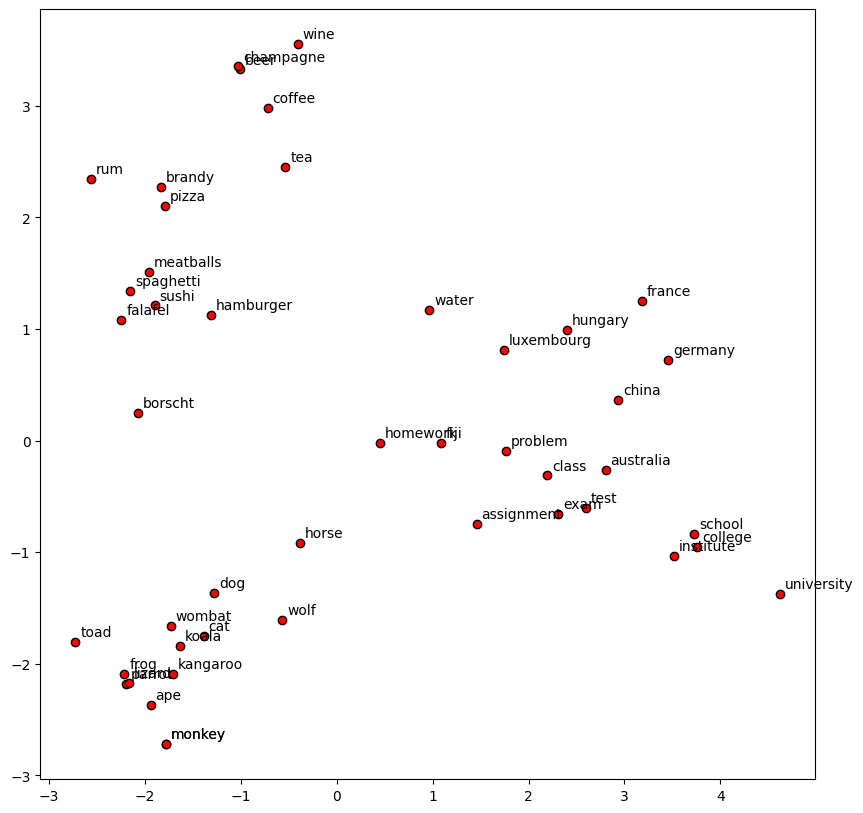

In [72]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

words = ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
        'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
        'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
        'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
        'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
        'homework', 'assignment', 'problem', 'exam', 'test', 'class',
        'school', 'college', 'university', 'institute']

word_vectors = np.array([model[w] for w in words])

twodim = PCA().fit_transform(word_vectors)[:,:2]  #transform 100 to 2 dimensions

plt.figure(figsize=(10,10))
plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
for word, (x,y) in zip(words, twodim):
    plt.text(x+0.05, y+0.05, word)
plt.show()